In [ ]:
import glob
import os
import shutil
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import json
from plotter import Plotter

from slack_sdk import WebClient
sc = WebClient(token=os.environ['SLACK_BEHAVIOR_BOT_TOKEN'])

In [1]:
folder_path = r'C:\data\behavior'
sync_path = r'Y:\behavior\detection_task'
print('Syncing C: to backups at ' + datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

new_day_folders = []

task_animals = glob.glob(os.path.join(folder_path, '*'))  # Get all animal folders

for animal_folder in task_animals:
    if 'test' not in animal_folder and os.path.isdir(animal_folder):  # Make sure it's a folder and not 'test'
        day_folders = glob.glob(os.path.join(animal_folder, '*'))  # Get all day folders within animal folder
        for day_folder in day_folders:
            if os.path.isdir(day_folder):  # Ensure it's a directory
                relative_path = os.path.relpath(day_folder, folder_path)
                sync_day_folder = os.path.join(sync_path, relative_path)
                
                if not os.path.exists(sync_day_folder):
                    os.makedirs(sync_day_folder)
                    print(f'Created directory: {sync_day_folder}')
                    new_day_folders.append(sync_day_folder)  # Track new day folder
                
                # Now handle files within each day folder
                for file in glob.glob(os.path.join(day_folder, '*')):
                    if os.path.isfile(file):
                        relative_file_path = os.path.relpath(file, folder_path)
                        sync_file = os.path.join(sync_path, relative_file_path)
                        
                        if not os.path.exists(sync_file):
                            os.makedirs(os.path.dirname(sync_file), exist_ok=True)
                            shutil.copy2(file, sync_file)
                            print(f'Copied file: {sync_file}')

print('Backup and plotting completed at ' + datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

# Now process any new day folders for summary plotting
for folder in new_day_folders:
    print(folder)
    
    # Find the first CSV file in the folder
    csv_file = glob.glob(os.path.join(folder, '*.csv'))[0]
    df = pd.read_csv(csv_file)
    
    json_file_path = glob.glob(os.path.join(folder, '*params.json'))[0]  
    # Open and read the JSON file
    with open(json_file_path, 'r') as json_file:
        json_content = json.load(json_file)  # This loads the content as a string if it's quoted
        if isinstance(json_content, str):
            # If the content is a string, parse it again to get the actual dictionary
            params = json.loads(json_content)
        else:
            # If it's already a dictionary, just use it directly
            params = json_content

    plotter = Plotter(params)
    plt.style.use(['dark_background','seaborn-v0_8-talk'])
    f, ax = plt.subplots(3, 2, figsize=(15,12))

    plotter.plot_outcomes_by_contrast(ax[0][0],df)
    plotter.plot_cumulative_count(ax[0][1],df)
    ax[0][1].set_title('Cumulative Counts')
    plotter.plot_wait_time_vs_starttime(ax[1][0], df)
    ax[1][0].set_title('Wait time by Outcome across session time')
    plotter.plot_rolling_proportion(ax[1][1],df)
    ax[1][1].set_title('Rolling Proportions')
    plotter.plot_wait_time_vs_contrast(ax[2][0], df)
    ax[2][0].set_title('Waitime by contrast and outcome')
    plotter.plot_reaction_time_vs_starttime(ax[2][1], df)
    ax[2][1].set_title('Reaction time by contrast')

    title = f"Summary Plot: {params['mouse']}, {params['start_time_string']}"
    plt.suptitle(title, size = 25)
    plt.tight_layout()
    file_str = os.path.join(folder, 'summary_plot.png')
    plt.savefig(file_str)
    # upload to slack
    response = sc.files_upload(channels = "#behavior_plot_bot", 
                               file = file_str, 
                               title = title)

Syncing C: to backups at 01/04/2024 16:41:49
Created directory: Y:\behavior\detection_task\jlh47\2024-04-01_11-04-31
Copied file: Y:\behavior\detection_task\jlh47\2024-04-01_11-04-31\2024-04-01_11-04-31.csv
Copied file: Y:\behavior\detection_task\jlh47\2024-04-01_11-04-31\lick_timestamps.npy
Copied file: Y:\behavior\detection_task\jlh47\2024-04-01_11-04-31\params.json
Copied file: Y:\behavior\detection_task\jlh47\2024-04-01_11-04-31\progress.png
Backup and plotting completed at 01/04/2024 16:41:55


Y:\behavior\detection_task\jlh47\2024-04-01_11-04-31


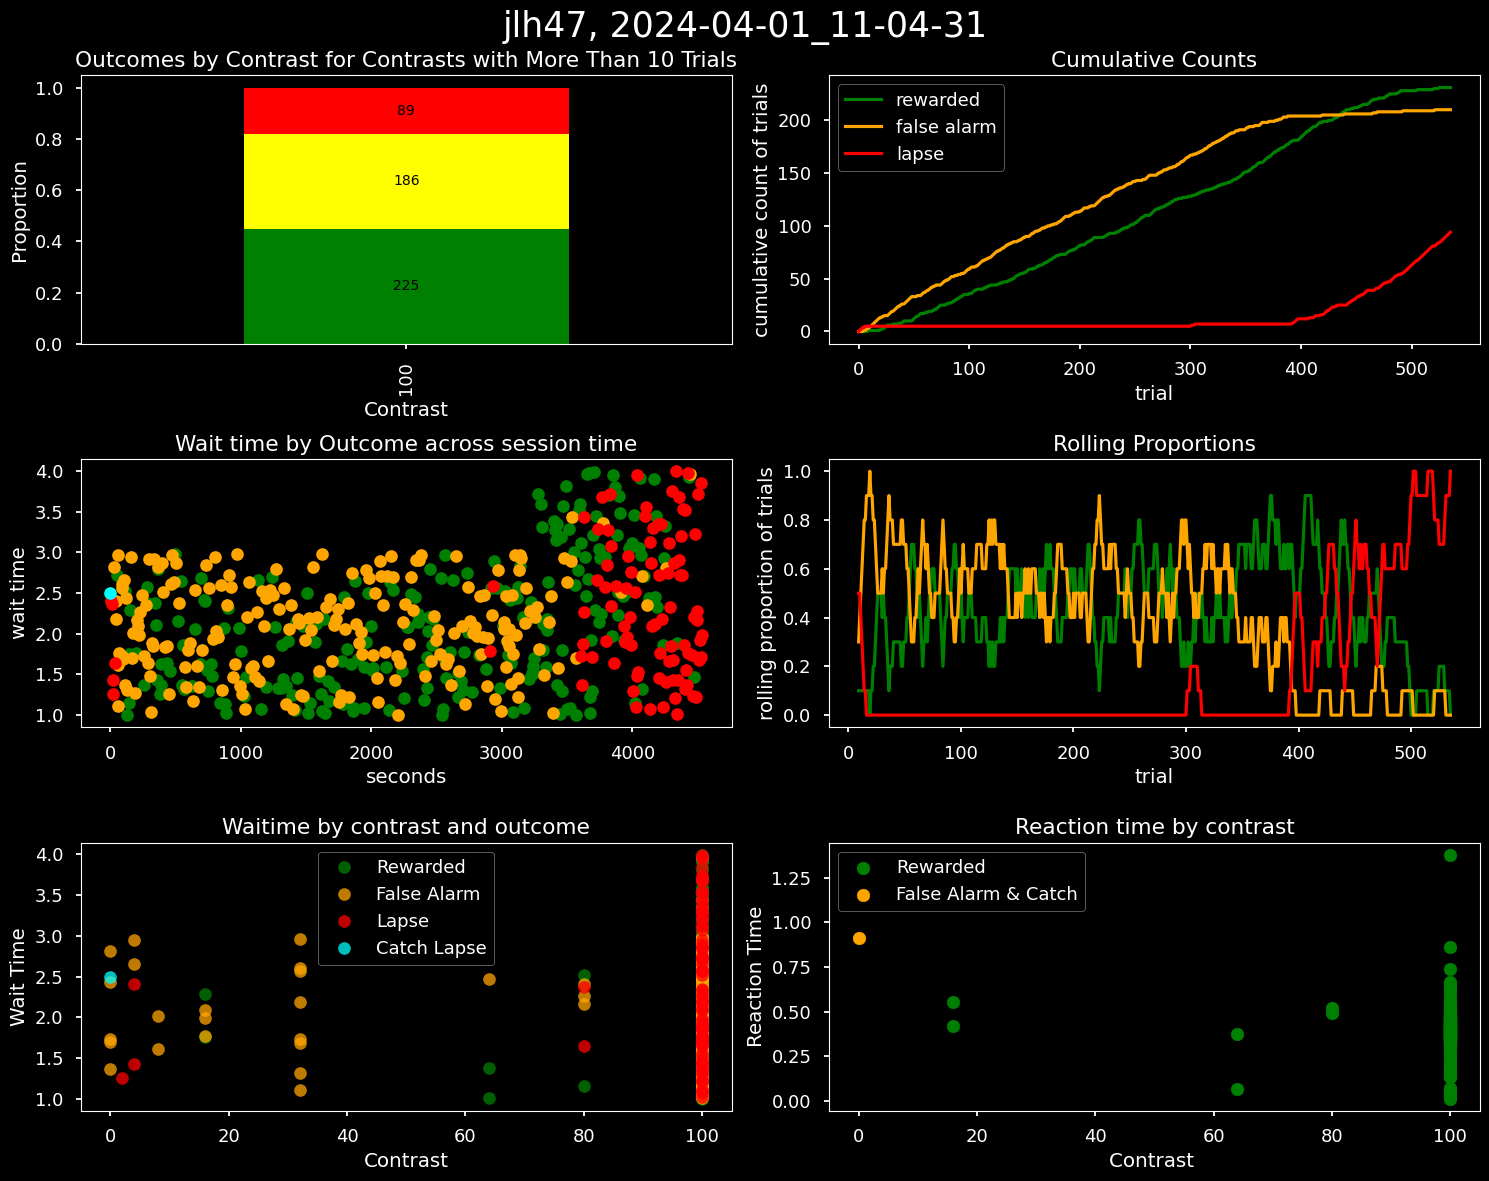